## Assignment 2 
By:<br>
**Taha Juzer Hussain (20231431)**<br>
**Mahewash Abdi (20230589)**



In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import scipy as sp
import cv2
import numpy as np
import pickle
import pandas as pd
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
import glob

### PART 1
#### Description of dataset:
The dataset for the classification problem consists of the images of two labels : **bird** and **cat**. <br>
Bing-image-downloader has been used which is a python library to download bulk images from Bing.com. The images were scraped using the different  species name of bird and cat. Using species names helped in avoiding undesirable images. Covering maximum species of bird and cat have been tried. <br>

**Training set:**
* bird - 416<br>
* cat - 571<br>

**Test set:**
* bird - 97 <br>
* cat - 93 <br>

All the images scraped are RGB images. The images from each category has been displayed below.

**Reference**<br>
* https://pypi.org/project/bing-image-downloader/

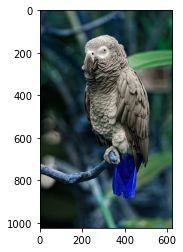

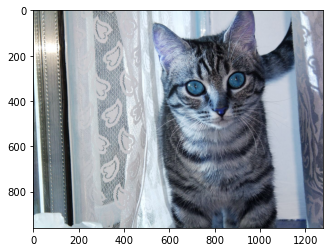

In [2]:
## Displaying images of bird and cat

path = 'dataset_2/bird/*.jpg'
it = glob.iglob(path)
first = next(it)
image=cv2.imread(first)
plt.imshow(image)
plt.show()

path = 'dataset_2/cat/*.jpg'
it = glob.iglob(path)
first = next(it)
image=cv2.imread(first)
plt.imshow(image)
plt.show()

### PART 2





**Pre-trained Classification model used:**<br>
Transfer learning has been used for the classification task where pre-trained model **InceptionV3** has been used. All the layers are non-trainable and a dense layer with 2 neurons has been added at the top since  we are performing binary classification.<br>

**Pre-processing:**<br>
Keras ImageDataGenerator has been used to expand the size of the dataset by using different data augmentation techniques such as shear transformation, horizontal flip and zoom. These augmentation techniques help in incorporating a level of variation in the dataset. All the images in the train and test set have been rescaled.<br>
The image size in the train and test data has been changed to (299,299) as this is the input shape that is compatible with the InceptionV3 model that we have used.

**Model:**<br>
InceptionV3 model has been used as base model for transfer learning. The top layer of the InceptionV3 model has been replaced by two layers:<br>

**1) Globalaveragepooling2d** - The shape of output of the base model is 2d and using this layer, it extracts the average value of each feature map and results into a scalar output. Since we have 2048 neurons in the output layer of the base model, this layer extracts 2048 values scalar values from each feature map.

**2) Dense layer** - A dense layer containing 2 neurons has been added on the Globalaveragepooling2d layer as we are dealing with binary classification problem. Only the top layer containing 2 neurons has been trained on the dataset containing images of birds and cats.<br>

The input shape of the images accepted by the InceptionV3 model(base model) is (299,299).

**Performance result:**
Accuracy metrics has been used to test the performance of the model.

Training set accuracy - 98.99%<br>
Test set accuracy - 99.47 %


**References**
* https://keras.io/api/applications/
* https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
* https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/
* https://medium.com/analytics-vidhya/transfer-learning-using-inception-v3-for-image-classification-86700411251b

In [33]:
## preprocessing of the image and data augmentation using different techniques

## Augmentation applied to the training images 
train_datagen = ImageDataGenerator(
        rescale=1./255, #scaled to range 0 and 1
        shear_range=0.2, # shear transformation
        zoom_range=0.2, #zoom
        horizontal_flip=True) # horizontal flip

## Augment applied to the training images 
test_datagen = ImageDataGenerator(rescale=1./255) ## scaled to range 0 and 1

## reading the images directly from the training directory and augmenting them while the model is training
training_set = train_datagen.flow_from_directory(
        'dataset_2/',
        target_size=(299, 299),
        batch_size=5,
        class_mode='binary'
        )

## Reading the test images from the directory and scaling is performed on all the images
test_set = test_datagen.flow_from_directory(
        'test_2/',
        target_size=(299, 299),
        batch_size=5,
        class_mode='binary',shuffle=True)



Found 981 images belonging to 2 classes.
Found 190 images belonging to 2 classes.


In [4]:
"""uncomment to save the augmented images in the directory. Create the folder first where the augmented 
image has to be saved, in the code below the generated_image is the directory which saves the augmented image"""

# i=0
# for batch in train_datagen.flow_from_directory(
#         'dataset_2/',
#         target_size=(299, 299),
#         batch_size=5,
#         save_to_dir="generated_image",
#         save_format ="jpeg",
#         color_mode="rgb"
#         ):
#     i+=1
#     if i > 4984:
#         break


'uncomment to save the augmented images in the directory. Create the folder first where the augmented \nimage has to be saved, in the code below the generated_image is the directory which saves the augmented image'

In [5]:
## InceptionV3 is used as the base model 
base_model = InceptionV3(input_shape=(299,299,3), ## shape of the image 
                               include_top = False, # last layer has been removed
                               weights = "imagenet")

## the layer in the base model are non-trainable and layer added after this will be trained
for layer in base_model.layers:
    layer.trainable = False
    

In [6]:
x = base_model.output   ## Shape (None,8,8,2048)

x = keras.layers.GlobalAveragePooling2D()(x) ## Results in scalar ouptut from each featuremap (None,2048). 2048 values are obtained as there are 2048 featuremaps 

predictions = keras.layers.Dense(2, activation='sigmoid')(x) ## dense layer with 2 neurons for classification
# this is the model we will train
model = keras.Model(inputs=base_model.input, outputs=predictions)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
__________________________________________________________________________________________________


In [8]:
#Compiling the model
model.compile(optimizer=RMSprop(lr=0.0001), ## learning rate = 0.0001
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc'])

In [22]:
## training of the model (only the layer added on the top model is trained) with training dataset

model.fit_generator(training_set,               
                    steps_per_epoch=80,
                    epochs=9
                   )

Epoch 1/9
80/80 [==============================] - 46s 570ms/step - loss: 0.0884 - acc: 0.9750
Epoch 2/9
80/80 [==============================] - 42s 521ms/step - loss: 0.0562 - acc: 0.9825
Epoch 3/9
80/80 [==============================] - 34s 419ms/step - loss: 0.0529 - acc: 0.9875
Epoch 4/9
80/80 [==============================] - 47s 593ms/step - loss: 0.0649 - acc: 0.9825
Epoch 5/9
80/80 [==============================] - 41s 512ms/step - loss: 0.0557 - acc: 0.9925
Epoch 6/9
80/80 [==============================] - 38s 472ms/step - loss: 0.0349 - acc: 0.9925
Epoch 7/9
80/80 [==============================] - 51s 641ms/step - loss: 0.0370 - acc: 0.9949
Epoch 8/9
80/80 [==============================] - 49s 609ms/step - loss: 0.0365 - acc: 0.9950
Epoch 9/9
80/80 [==============================] - 46s 576ms/step - loss: 0.0346 - acc: 0.9899


In [23]:
model.evaluate(test_set) ## Evaluation on the test set

38/38 [==============================] - 10s 242ms/step - loss: 0.0257 - acc: 0.9947


[0.02568701282143593, 0.9947368502616882]

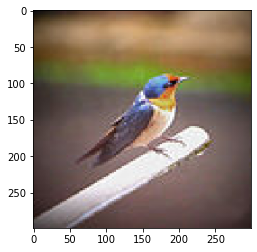

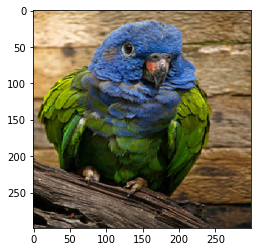

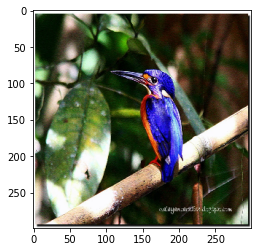

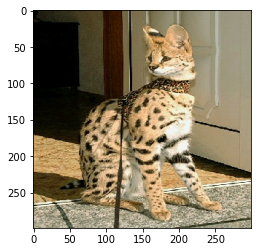

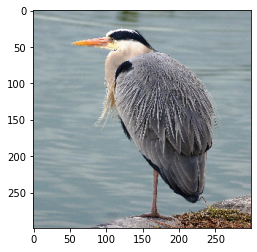

In [34]:
## Displaying 5 images from the test dataset
for i in test_set[0][0]:
    plt.imshow(i)
    plt.show()

In [35]:
## predicted output of the model
model.predict(test_set[0][0])

array([[0.9575276 , 0.06269478],
       [0.86856383, 0.1709863 ],
       [0.9252193 , 0.17477907],
       [0.05511556, 0.93334854],
       [0.84536844, 0.16005813]], dtype=float32)

In [36]:
## Mapping the class label with the names of the label in the classification set
v = model.predict(test_set[0][0])
classes = {0:"bird",1:"cat"}

In [37]:
## The names of the class label predicted by the model
np.argmax(v[0])
predicted = []
for i in v:
    class_label = np.argmax(i)
    predicted.append(class_label)

predicted_class = [classes[i] for i in predicted]
print(predicted_class)

['bird', 'bird', 'bird', 'cat', 'bird']


### PART 3

In this part, the outputs of base model are taken and layers of GlobalAveragePooling2D and softmax are added and a model is created. Using global average pooling gives some advantages over dense layer as discussed below. The model takes an input of image with dim (299, 299) and outputs a scalar output of probabilities of dim(None,2048). The output represents the probability of each neuron in classifying the object into its class. Higher probabilty represent important neuron in identifying the class.

Using global average pooling over the fully connected layer provides correspondences between feature maps and categories. Thus the feature maps can be easily interpreted as categories confidence maps. 
Another advantage is that there is no parameter to optimize in the global average pooling thus overfitting is avoided at this layer. Futhermore, global average pooling sums out the spatial information, thus it is more robust to spatial translations of the input.

**Calculating Correlation**

We used 190 images from the test set and predicted set of softmax probabilities for them. After calculating the probabilty of each neuron we created a pandas dataframe and calculated pearson correlation between the output of the softmax and the class labels. This results in extracting strongly correlated neurons with the class label.Later, we selected the top 9 neurons which are highly correlated with the labels.

**Result interpretation**



*   The model created in part 3, outputs softmax probabilities of each feature map recieved from GlobalAveragePooling2D. This represents which features are more important in helping the class of image.

*   The correlation calculated using 190 images represents the neurons which are highly correlated with the classes of image. The neurons with highest correlation show that they are important in identifying class for both type of images.

* As the correlation is calculated using examples from both the classes, the top 9 neurons which are selected represents generalized features for both the classes.

* These top 9 neurons can be seen as weak class detectors.   

**References**

* Lin, Min & Chen, Qiang & Yan, Shuicheng. (2013). Network In Network. 

* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html 

In [38]:
# using the base model and adding layer of global average pooling
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
output = keras.activations.softmax(x)
model_2 = keras.Model(inputs=model.inputs,outputs=output)

In [39]:
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [40]:
# creatign step size
batch_size= 5
total_img = test_set.n
step = total_img//batch_size  ## step = 40 

In [41]:
# creating test set and label set from the images
test_image=[]  ## contains all the images 
label=[]
for i in range(step):
    x,y = test_set.next()    
    test_image.extend(x)
    label.extend(y)

In [42]:
test_images = np.array(test_image)
print("The total number of images in the test_image: ",len(label))

The total number of images in the test_image:  190


In [43]:
"""softmax_ouptut contains the probabilities assigned to each hidden neuron depending on the value of the feature 
map for 2048 hidden neurons"""

softmax_output = model_2.predict(test_images)

In [44]:
## dataframe containing the softmax output as independent features and label of the images in the test data as the dependent feature
df = pd.DataFrame(softmax_output)
df['label'] = label

In [45]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,label
0,0.000351,0.000448,0.000364,0.000401,0.000569,0.000357,0.000351,0.000569,0.000389,0.000420,...,0.000531,0.000598,0.000613,0.001232,0.000475,0.000417,0.000809,0.000744,0.000439,1.0
1,0.000417,0.000385,0.000394,0.000607,0.000866,0.000656,0.000416,0.000779,0.000387,0.000650,...,0.000386,0.001121,0.000823,0.000815,0.000808,0.000735,0.000680,0.000634,0.000703,1.0
2,0.000426,0.000537,0.000442,0.000450,0.000477,0.000442,0.000419,0.000493,0.000428,0.000417,...,0.000415,0.000407,0.000444,0.000776,0.000559,0.000597,0.000517,0.000389,0.000716,1.0
3,0.000349,0.000385,0.000330,0.000400,0.000401,0.000379,0.000332,0.000417,0.000453,0.000415,...,0.000415,0.000440,0.000435,0.000791,0.000669,0.000510,0.000839,0.000815,0.000410,1.0
4,0.000408,0.000512,0.000405,0.000514,0.000412,0.000515,0.000513,0.000389,0.000459,0.000445,...,0.000470,0.000536,0.000548,0.000510,0.000396,0.000549,0.000426,0.000440,0.000423,0.0


In [46]:
## finding correlation of the class label with the input features
corr = df.corr()['label']

## top 10 high correlated neurons

top_10 = np.argsort(corr)[-10:][::-1]
high_corr_neuron = top_10[1:]

high_corr_neuron   ## List of top 9 highly correlated neurons

2047    1752
2046     201
2045    1188
2044    1217
2043     248
2042    1523
2041    1145
2040    1396
2039    1547
Name: label, dtype: int64

In [47]:
## correlation values corresponding to each neuron
corr[high_corr_neuron]

1752    0.704583
201     0.674968
1188    0.671028
1217    0.667104
248     0.650950
1523    0.648499
1145    0.625867
1396    0.625736
1547    0.616534
Name: label, dtype: float64

### Part 4

In this part, we have visualized neurons which are highly correlated in part 3. These neurons can be identified as important features of an image in classifying the class. 

To perform object localisation, we have used the technique of Class Activation Mapping. Class activation maps can be used to intepret the prediction decision made by the CNN. It makes the use of global average pooling to find the neurons which are important in predicting the class. It takes the output from layer before global average pooling which represent the features of an image and the weights from the final dense layer. It then performs a dot product to represents the most important features that the CNN uses to classify the image. Therefore, the most important features could be used to localize the object in an image.

In our case, we have used the features output by the base model of our pre-trained model and the weights are taken as the values from the softmax layer. To see if the neurons which are highly correlated could be used to localize the object, we used the values from softmax for those neurons and kept all other values as zero. This would show features of the neurons which are highly correlated.

After calculating the dot product, we have tried to impose those features on the image and visualized them. As per the visualization, it could be clearly observed that the highly correlated features can efficiently localize the object. 

We have performed this on multiple images and results shows that object localization is possible using the strongly correlated neurons.. 

Further, changes could be done in the selection of correlated neurons, where we can try selecting different top n neurons (in this case 9). More neurons could result in better object localization.



References

* B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015)

* http://cnnlocalization.csail.mit.edu/

* Lecture notes

* https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.zoom.html 

In [48]:
# creating a model with inputs as model inputs and output as the features from the CNN and output of the dense layer
cam_model = keras.Model(inputs = model.input, outputs =(model.get_layer('mixed10').output,model.get_layer('dense').output))

In [49]:
cam_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

mixed8 (Concatenate)            (None, 8, 8, 1280)   0           activation_71[0][0]              
                                                                 activation_75[0][0]              
                                                                 max_pooling2d_3[0][0]            
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 8, 8, 448)    573440      mixed8[0][0]                     
__________________________________________________________________________________________________
batch_normalization_80 (BatchNo (None, 8, 8, 448)    1344        conv2d_80[0][0]                  
__________________________________________________________________________________________________
activation_80 (Activation)      (None, 8, 8, 448)    0           batch_normalization_80[0][0]     
__________________________________________________________________________________________________
conv2d_77 

### Visualizing the 2d output of the strongly correlated neurons

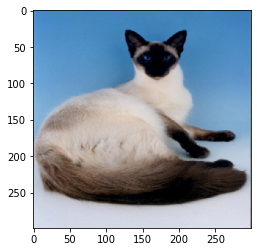

In [50]:
plt.imshow(test_images[1])

In [51]:
## Converting the images shape so that the image shape is compatible with layer model_2 shape which is (none,299,299,3)
test_images_reshaped = test_images[1].reshape((1,299,299,3))
feature_viz, result_img = cam_model.predict(test_images_reshaped)
feature_viz.shape

(1, 8, 8, 2048)

In [52]:
high_corr_neuron

2047    1752
2046     201
2045    1188
2044    1217
2043     248
2042    1523
2041    1145
2040    1396
2039    1547
Name: label, dtype: int64

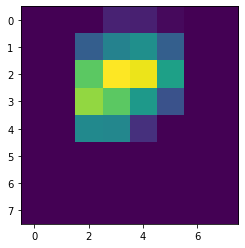

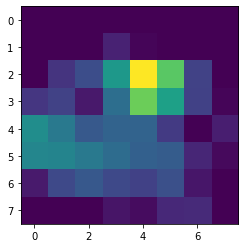

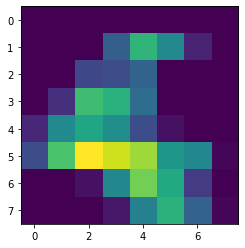

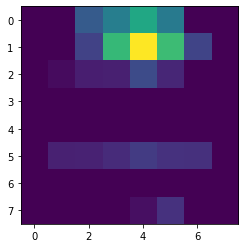

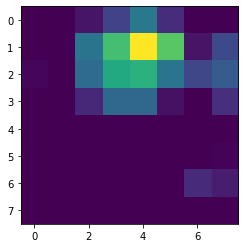

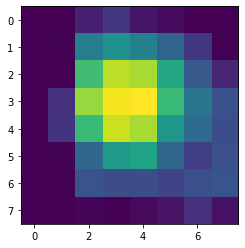

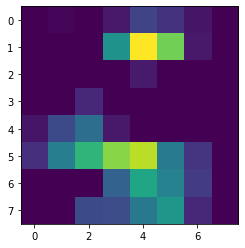

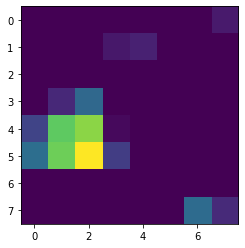

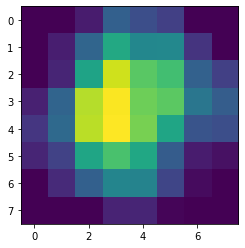

In [53]:
## Plotting the 2d output of the strongly correlated neurons (top 9 neurons are selected)
for i in high_corr_neuron:
    plt.imshow(feature_viz[0,:,:,i])
    plt.show()
    

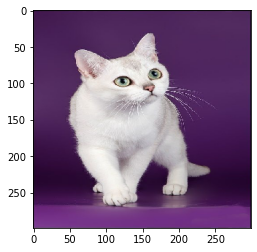

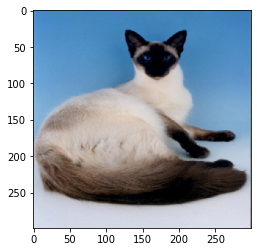

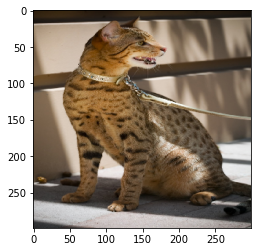

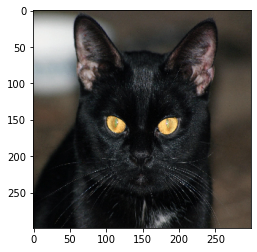

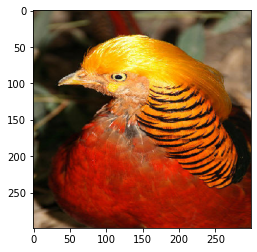

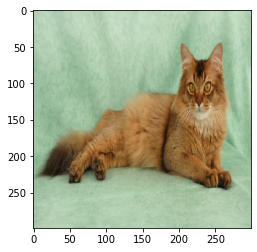

In [56]:
## selecting 10 images from the test data 
for i in range(6):
    plt.imshow(test_images[i])
    plt.show()
       


In [57]:
## saving 2D output of the neuron and predicted label of the 6 images from test data in 'features' and 'result' respectively

features,result = cam_model.predict(test_images[0:6])
print("feature shape:",features.shape)
print("result shape:",result.shape)

feature shape: (6, 8, 8, 2048)
result shape: (6, 2)


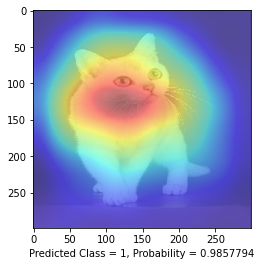

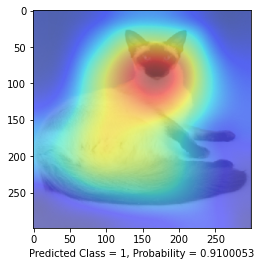

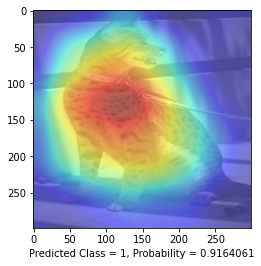

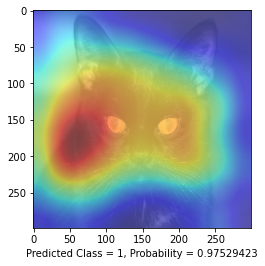

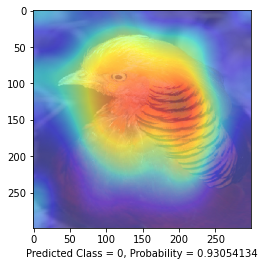

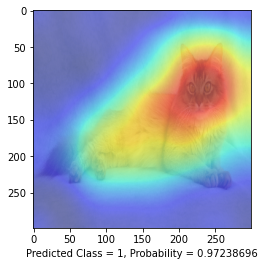

In [58]:
for ind in range(6):
    feature_for_one_image = features[ind,:,:,:] # extracting features for a single image
    height_zoomout = 299/features.shape[1]
    width_zoomout  = 299/features.shape[2]

    cam_features = sp.ndimage.zoom(feature_for_one_image, (height_zoomout, width_zoomout,1), order=2) # zooming the array to match the image dimensions
    predicted_label = np.argmax(result[ind]) # predicting the label
    plt.figure(facecolor='white')
    
    high_corr_feature = np.zeros((2048,)) # creating an array of zeros with dim same as softmax output
    for j in high_corr_neuron:
        high_corr_feature[j] = softmax_output[i,j]   # setting values of highly correlated neurons as present and others as zero
    
    cam_output  = np.dot(cam_features,high_corr_feature) # performing a dot product with the features and value of neurons
    
    
    buf = 'Predicted Class = ' + str ( predicted_label ) + ', Probability = ' + str(result[ind][predicted_label])
    # plotting the images
    plt.xlabel(buf)
    plt.imshow(np.squeeze(test_images[ind]), alpha=0.5)
    plt.imshow(cam_output, cmap='jet', alpha=0.5)
    

### Link to download the datasets:
* Training data(dataset_2): https://nuigalwayie-my.sharepoint.com/:f:/g/personal/m_abdi2_nuigalway_ie/Ev8FyWldaK5DlWSvexG66Q0BIV3c_VDvzso4HcLIbW8efw?e=BwFVjW
* Test data (test_2) : https://nuigalwayie-my.sharepoint.com/:f:/g/personal/m_abdi2_nuigalway_ie/EpncmO38zUtHhsb_NLs8QzwBCgprrkf-h2D0JbF76q4XjA?e=Ba39EH